In [1]:
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
import os
from torch_geometric.data import HeteroData, Batch
import ujson

# Used for finding full path based on name of contract
def find_string_with_substring(strings, substring):
    return [s for s in strings if substring in s]

def build_dataset(repo_paths,embedding_model,is_query):
    datas=[]
    for repo_path in repo_paths:
        nodes = {} #function name: {id,code}
        edges = {
            ('function', 'parent_contract', 'function'): [], #in list there will be ids of function with this relationship
            ('function', 'internal_call', 'function'): [],
            ('function', 'high_level_call', 'function'): [],
            ('function', 'library_call', 'function'): [],
            ('function', 'low_level_call', 'function'): []
        }
        node_id=0
        full_paths = []
        # Walk through the directory tree
        for subdir, _, files in os.walk(repo_path):
            for file_name in files:
                full_path = os.path.join(subdir, file_name)
                full_paths.append(full_path)
        print(repo_path, ' amount functions: ',len(full_paths))
    
        # give id to all nodes and encode
        for node_id, full_path in tqdm(enumerate(full_paths), position=0, leave=True):
            # Load the function code JSON
            try:
                with open(full_path, 'r') as f:
                    function_data = ujson.load(f)
            except:
                print('error ',full_path)
                continue
            
            embeds=embedding_model(function_data["Code"],is_query) #TODO: accumulate into batch and pass
            nodes[full_path] = {
                "id": node_id,
                "code": embeds
            }
        # Remember all edges
        for full_path in full_paths:
            # Load the function code JSON
            try:
                with open(full_path, 'r') as f:
                    function_data = ujson.load(f)
            except:
                print(f"parsing error {full_path}")
                continue
            node_id = nodes[full_path]['id']
    
            # Create edges based on the calls
            for parent_contract in function_data["Parent Contracts"]:
                parent_contract_path = find_string_with_substring(full_paths,parent_contract) # find real path of file
                if parent_contract_path!=[] and parent_contract_path in nodes: #check if function is processed into .txt
                    edges[('function', 'parent_contract', 'function')].append((nodes[parent_contract_path[0]]["id"], node_id))
    
            for internal_call in function_data["Internal Calls"]:
                internal_call_path = find_string_with_substring(full_paths,internal_call)
                if internal_call_path!=[] and internal_call_path[0] in nodes:
                    edges[('function', 'internal_call', 'function')].append((node_id, nodes[internal_call_path[0]]["id"]))
    
            high_level_calls = function_data["High-Level Calls"]
            if len(high_level_calls) != 0 and isinstance(high_level_calls[0], list):
                high_level_calls = [] # unpack list of lists
                for lst in high_level_calls:
                  for elem in lst:
                    high_level_calls.append(elem)
                      
            for high_level_call in high_level_calls:
                high_level_call_path = find_string_with_substring(full_paths,high_level_call)
                if high_level_call_path!=[] and high_level_call_path[0] in nodes:
                    edges[('function', 'high_level_call', 'function')].append((node_id, nodes[high_level_call_path[0]]["id"]))
    
            for library_call in function_data["Library Calls"]:
                library_call_path = find_string_with_substring(full_paths,library_call)
                if library_call_path!=[] and library_call_path[0] in nodes:
                    edges[('function', 'library_call', 'function')].append((node_id, nodes[library_call_path[0]]["id"]))
    
            for low_level_call in function_data["Low-Level Calls"]:
                low_level_call_path = find_string_with_substring(full_paths,low_level_call)
                if low_level_call_path!=[] and low_level_call_path[0] in nodes:
                    edges[('function', 'low_level_call', 'function')].append((node_id, nodes[low_level_call_path[0]]["id"]))
    
        data = HeteroData()
    
        # Create node type function
        repo_funcs_embeddings=[nodes[func]["code"].squeeze(0) for func in nodes] #len(list)=amount_files list([256,256])
        data['function'].x =torch.stack(repo_funcs_embeddings)
        
        # print(data['function'].x.shape)
        
        for edge_type, edge_list in edges.items():
            if edge_list:
                data[edge_type].edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        
        print(repo_path,' nodes ',len(nodes),' edges ',len(edges.values()))
        if edges[('function', 'high_level_call', 'function')]!=[] or edges[('function', 'internal_call', 'function')]!=[] or edges[('function', 'parent_contract', 'function')]!=[] or edges[('function', 'library_call', 'function')]!=[]:
            # torch.save(data, f'./data/data/pyg_datasets/{repo_name}.pt')
            pass
        else:
          print("Have no edges")
        datas.append(data)

    # list to one dataset
    combined = Batch.from_data_list(datas)
    return combined

def sample_negatives(t_n,shape):
    # TODO: negative samples should not be randomly chosen
    # Train adversarial network? :|
    indexes=torch.randint(0, t_n.shape[0], (shape[0],))
    lst=[t_n[idx]for idx in indexes]
    return torch.stack(lst)

def shuffle_pos_neg(t_p, t_n, device):
    pos_labels = torch.ones(t_p.size(0), device=device)
    neg_labels = torch.zeros(t_n.size(0), device=device)
    
    # Combine samples and labels
    combined_samples = torch.cat((t_p, t_n), dim=0)
    combined_labels = torch.cat((pos_labels, neg_labels), dim=0)
    
    # Generate random permutation indices
    num_samples = combined_samples.size(0)
    perm = torch.randperm(num_samples, device=device)
    
    # Shuffle both samples and labels using the same permutation
    shuffled_samples = combined_samples[perm]
    shuffled_labels = combined_labels[perm]
    
    return shuffled_samples, shuffled_labels.unsqueeze(1).float()

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from torch_geometric.nn import HeteroConv, SAGEConv, global_mean_pool

# Initial node (function) embeddings before message passing
class NodeEmbeddings(torch.nn.Module):
    def __init__(self,tokenizer,model,func_sig_end_symbol):
        super().__init__()
        self.tokenizer = tokenizer
        self.model = model
        self.pool=nn.AdaptiveAvgPool2d(output_size=(4096,4096)) #[seq_len,token_dim]
        # no idea about what can be good parameters of augpool. Maybe 1d pooling twice?
        self.augpool=nn.FractionalMaxPool2d((32,128), output_size=(1024, 1024))
        # channels are splitted into 256 groups of 4 channels. Enables inside token conv
        self.insidetokenconv=nn.Conv2d(kernel_size=(1,1),in_channels=1024,out_channels=256,groups=256)
        # captures patterns in 8, 8*2, 8*4 windows 
        self.intertokenconv1=nn.Conv2d(kernel_size=(1,8),stride=(1,4),dilation=(1,1),padding=(0,2),in_channels=256, out_channels=128)
        self.intertokenconv2=nn.Conv2d(kernel_size=(1,8),stride=(1,4),dilation=(1,2),padding=(0,7),in_channels=256, out_channels=128)
        self.intertokenconv3=nn.Conv2d(kernel_size=(1,8),stride=(1,4),dilation=(1,4),padding=(0,13),in_channels=256, out_channels=128)
        self.linear=nn.Linear(768,32)
        self.func_sig_end_symbol=func_sig_end_symbol

    def __call__(self, text, is_query): # one function
        if is_query:
            code_start_idx=text.find(self.func_sig_end_symbol)
            text=text[code_start_idx:]
        
        tokens = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        # tokens to device
        tokens = {key: val.to(device) for key, val in tokens.items()}
        # aint using saved embeddings since they are too large to be saved for each repo (1tb)
        with torch.no_grad(): 
            # those embeddings are from encoder, meaning they are enriched by attention with tokens before and after token
            outputs = self.model(**tokens).last_hidden_state # [1,current_seq_len,4096]
            # 1*400*4000*4096*2/1024/1024/1024=12gb per repo raw
        # print(torch.sum(outputs))
        # outputs.last_hidden_state.mean(dim=1).squeeze(0)
        # Mean pool across the sequence dimension for fixed-size embedding
        # Mean pool is not trainable
        # Too much information is lost (seq_len times)
        
        # variable-token length to static dimensions
        outputs=self.pool(outputs) #[1,4096,4096]
        # print(outputs.shape)
        # print(torch.sum(outputs))
        
        # apply pooling with randomness (augpool) to
        # 1) 0.5mb graph -> 12gb raw outputs -> 50mb initembeddings. Lots of data to learn
        # 2) introduce augmentation on small (25mb) dataset
        # 3) embeddings gives supplemental data 
        outputs=self.augpool(outputs) 
        outputs=torch.unsqueeze(outputs,dim=2)#[1,1024,1,1024]
        # print(torch.sum(outputs))
        # print(outputs.shape)
        
        outputs=self.insidetokenconv(outputs) #[1,256,1,1024]
        # print(torch.sum(outputs))
        # print(outputs.shape)

        # Code inherently structured in blocks, with neighbouring tokens be one block with high chance
        # Convolutions may be used to find those blocks
        # itransformer suggest to keep token_dim untouched
        # outputs=outputs.permute(0,3,2,1)
        # print(torch.sum(outputs))
        # print(outputs.shape)
        outputs1=self.intertokenconv1(outputs)#[1,256,1,128]
        outputs2=self.intertokenconv2(outputs)#[1,256,1,128]
        outputs3=self.intertokenconv3(outputs)#[1,256,1,128]
        outputs=torch.cat((outputs1,outputs2,outputs3),dim=3) #[1, 128, 1, 768]
        # print(outputs.shape)
        # print(torch.sum(outputs))

        # Think block. Transpose above let think on dim=feature
        outputs=self.linear(outputs)#[1,256,32]
        outputs=torch.flatten(outputs, start_dim=1) #[1,8192]
        # print(torch.sum(outputs))
        return outputs # [batch=num_nodes=1,node_embeddings]

class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, in_channels, hidden_channels, out_channels, num_layers=3, use_edge_features=True):
        super(HeteroGNN, self).__init__()

        self.node_types = metadata[0]
        self.edge_types = metadata[1]
        self.num_layers = num_layers
        self.use_edge_features = use_edge_features

        # first convolution
        first_conv_dict = {
            (src, rel, dst): SAGEConv(in_channels, hidden_channels)
            for src, rel, dst in self.edge_types
        }
        self.first_conv=HeteroConv(first_conv_dict)
        
        # middle convolutions
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers-2):
            conv_dict = {}
            for edge_type in self.edge_types:
                src, rel, dst = edge_type
                conv_dict[(src, rel, dst)] = SAGEConv(hidden_channels, hidden_channels)
            self.convs.append(HeteroConv(conv_dict))
        # final convloution
        final_conv_dict = {
            (src, rel, dst): SAGEConv(hidden_channels, out_channels)
            for src, rel, dst in self.edge_types
        }
        self.final_conv = HeteroConv(final_conv_dict)

        # Pooling layer to aggregate different types of nodes embeddings into a graph embedding
        # self.pool = global_mean_pool

    def forward(self, data):
        x_dict = {node_type: data[node_type].x for node_type in self.node_types}
        # edge_index_dict = {edge_type: data[edge_type].edge_index for edge_type in self.edge_types}
        edge_index_dict = {}
        for edge_type in self.edge_types:
            if edge_type in data:
                edge_index_dict[edge_type]= data[edge_type].edge_index
            else:
                edge_index_dict[edge_type]=torch.zeros((2,0),dtype=torch.int32,device=device)
        
        x_dict=self.first_conv(x_dict,edge_index_dict)
        for i in range(self.num_layers-2):
            # print(i)
            x_dict = self.convs[i](x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        x_dict = self.final_conv(x_dict, edge_index_dict)

        x = torch.cat([x_dict[node_type] for node_type in self.node_types], dim=0)
        # Since we have only one node type, pass zeros
        # graph_embedding = self.pool(x, torch.zeros(x.shape, dtype=torch.long, device=de))
        batch_dict = {nt: data[nt].batch for nt in self.node_types}
        return x, batch_dict

class GMN(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def __call__(self,anchor_graph,positive_graph,negative_graph,node_batch_a,node_batch_p,node_batch_n):
        # positive obtained from same graph as anchor, but with augmentations
        uniq,count_a=torch.unique(node_batch_a['function'],return_counts=True)
        uniq,count_n=torch.unique(node_batch_n['function'],return_counts=True)
        ends_a=torch.cumsum(count_a,dim=0)
        starts_a=torch.cat([torch.tensor([0], device=ends_a.device), ends_a[:-1]])
        ends_n=torch.cumsum(count_n,dim=0)
        starts_n=torch.cat([torch.tensor([0], device=ends_n.device), ends_n[:-1]])

        anchor_gmn=[]
        pos_gmn=[]
        neg_gmn=[]
        for i in range(len(starts_a)):
            graph_a=anchor_graph[starts_a[i]:ends_a[i],:]
            graph_p=positive_graph[starts_a[i]:ends_a[i],:]
            graph_n=negative_graph[starts_n[i]:ends_n[i],:]
            
            concat=torch.cat((graph_a, graph_p, graph_n), dim=0)
            # print(concat.shape) # [num_nodes,num_param]

            # try different vector sim functions
            sims=torch.matmul(concat, concat.T) # [num_nodes,num_nodes]
            # print(sims.shape)
            matching=concat-sims@concat
            gmn_a,gmn_p,gmn_n=torch.split(matching,[graph_a.shape[0],graph_p.shape[0],graph_n.shape[0]])
            anchor_gmn.append(gmn_a)
            pos_gmn.append(gmn_p)
            neg_gmn.append(gmn_n)
            
        # print(matching.shape)
        anchor_gmn = torch.cat(anchor_gmn, dim=0)
        pos_gmn = torch.cat(pos_gmn, dim=0)
        neg_gmn = torch.cat(neg_gmn, dim=0)
        return anchor_gmn,pos_gmn,neg_gmn

# model weights 255MB
class LinkPredictorHead(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(kernel_size=(1,4),padding=(0,1),in_channels=2,out_channels=256)
        self.conv2=nn.Conv2d(kernel_size=(1,4),padding=(0,1),in_channels=256,out_channels=128)
        self.norm1=nn.BatchNorm1d(128*1*254)
        self.linear1=nn.Linear(128*1*254, 2048)
        self.norm2=nn.BatchNorm1d(2048)
        self.linear2=nn.Linear(2048, 1)
        self.sigmoid=nn.Sigmoid()
    def __call__(self,nodes1,nodes2): 
        nodes1=nodes1.unsqueeze(dim=0)# [1, num_nodes, 256])
        nodes2=nodes2.unsqueeze(dim=0)# [1, num_nodes, 256]
        out=torch.concatenate((nodes1,nodes2)) # [2,num_nodes,256]
        out=out.permute(1,0,2).unsqueeze(2) #[num_nodes,chan=2,h=1,w=256]
        # print(out.shape) 
        out=self.conv1(out)
        # print(out.shape)
        out=self.conv2(out)
        # print(out.shape)
        out=out.flatten(start_dim=1,end_dim=3) # [num_nodes, 128*1*254]
        # print(out.shape)
        out=self.norm1(out)
        out=self.linear1(out)#[num_nodes,2048]
        out=self.norm2(out)
        out=self.linear2(out)#[2048,1]
        # print(out.shape)
        # out=self.sigmoid(out) remove since bcewithlogitloss
        return out

# class BugMapperHead(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.mlp=linear()
#     def __call__(self,nodes):
#         out=self.linear(nodes)
#         return out

In [3]:
# TODO: use previous positive as next negative
batch_info=None
class MetaEmbedderModel(nn.Module):
    def __init__(self, tokenizer, model, func_sig_end_symbol, hidden_channels=1024, out_channels=256):
        super().__init__()
        self.initial_embedder = NodeEmbeddings(tokenizer,model,func_sig_end_symbol).to(device)
        self.gmn = GMN().to(device)
        self.dataset_metadata=None
        self.gnn_embedder=None
        
    def setup_metadata(self):
        # metadata manual run
        initial_embeddings_a=build_dataset(['./data/data/processed_repositories/2024-12-lambowin'],self.initial_embedder,False).to(device)
        self.dataset_metadata=initial_embeddings_a[0].metadata()
        self.gnn_embedder=HeteroGNN(self.dataset_metadata, in_channels=4096, hidden_channels=1024, out_channels=256).to(device)
    
    def forward(self,repo_paths_1,repo_paths_2):
        # pyg datasets
        initial_embeddings_a=build_dataset(repo_paths_1,self.initial_embedder,True).to(device) #query cuts string till first func_sig_end_symbol
        initial_embeddings_p=build_dataset(repo_paths_1,self.initial_embedder,False).to(device)
        initial_embeddings_n=build_dataset(repo_paths_2,self.initial_embedder,False).to(device)
        
        # Enrich embeddings with message passing
        gnn_embeddings_a, node_batch_a=self.gnn_embedder(initial_embeddings_a) #[total_num_nodes_batch,node_dim]
        gnn_embeddings_p, node_batch_p=self.gnn_embedder(initial_embeddings_p)
        gnn_embeddings_n, node_batch_n=self.gnn_embedder(initial_embeddings_n)
        # print(gnn_embeddings_a.shape,gnn_embeddings_p.shape,gnn_embeddings_n.shape)
        
        # and GMN crossgraph attention to facilate intragraph embeddings
        gmn_a,gmn_p,gmn_n=self.gmn(gnn_embeddings_a,gnn_embeddings_p,gnn_embeddings_n,node_batch_a,node_batch_p,node_batch_n)
        print(gmn_a.shape,gmn_p.shape,gmn_n.shape)
        #TODO: Use gru instead of sum
        gnn_embeddings_a+=gmn_a
        gnn_embeddings_p+=gmn_p
        gnn_embeddings_n+=gmn_n
        
        return gnn_embeddings_a,gnn_embeddings_p,gnn_embeddings_n

# train embeddings:
# link_predictor

# Task=generation
# test time learning? need overfit on repo, only then produce new code
# model_generator=CodeGenerator(model,prompt) 
# lora? for repository specific adjustment
# generation_loss = 

# Task=bugsearch
# model_bugsearch=BugMap()
# modify embeddings and check if similar to bug
# mapping_loss

In [ ]:
from tqdm import tqdm
import random

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# import gc
# gc.collect()
# torch.cuda.empty_cache() 
print(f"Using device: {device}")

model=AutoModel.from_pretrained("./model/base").to(device).eval()
tokenizer=AutoTokenizer.from_pretrained("./model/base")
func_sig_end_symbol='{' # for solidity
metamodel=MetaEmbedderModel(tokenizer,model,func_sig_end_symbol).to(device)
metamodel.setup_metadata()
task_model=LinkPredictorHead().to(device)

link_loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer_meta=torch.optim.Adam(metamodel.parameters(),lr=0.00001)
optimizer_link=torch.optim.Adam(task_model.parameters(),lr=0.00001)
epoch=2
batch_size=4
epochs_losses=[]
epochs_metrics=[] # [0:[preds_probs,answers],1:[preds_probs,answers]]

def calc_metrics(probs, targets, threshold=0.5):
    preds = (probs > threshold).float()
    targets = targets.float()
    
    true_pos = (preds * targets).sum().float()
    false_pos = (preds * (1 - targets)).sum().float()
    false_neg = ((1 - preds) * targets).sum().float()
    
    precision = true_pos / (true_pos + false_pos + 1e-10)  # Avoid division by zero
    recall = true_pos / (true_pos + false_neg + 1e-10)
    
    return {
        'precision': precision.item(),
        'recall': recall.item(),
        'f1': (2 * precision * recall / (precision + recall + 1e-10)).item()
    }

def train_batch(metamodel,task_model,optimizer_meta,optimizer_link,loss_fn,batch_p,batch_n):
    optimizer_meta.zero_grad()
    optimizer_link.zero_grad()
    
    gnn_embeddings_a,gnn_embeddings_p,gnn_embeddings_n=metamodel(batch_p,batch_n)
    # take negatives to match anchor shape
    sampled_negatives=sample_negatives(gnn_embeddings_n,gnn_embeddings_a.shape) # [num_pos,2] each node will have 1 pos and 1 neg
    # shuffle positive and negative to prevent cheating
    shuffled_pn,targets=shuffle_pos_neg(gnn_embeddings_p,sampled_negatives,device)
    # currently model compares node:[node], need node:[node1,node2,...]
    link_predictions1=task_model(gnn_embeddings_a,shuffled_pn[:gnn_embeddings_a.shape[0]]) # [num_nodes_a,1]
    link_predictions2=task_model(gnn_embeddings_a,shuffled_pn[gnn_embeddings_a.shape[0]:]) # [num_nodes_a,1]
    loss = loss_fn(link_predictions1, targets[:gnn_embeddings_a.shape[0]])+loss_fn(link_predictions2, targets[gnn_embeddings_a.shape[0]:])
    link_predictions=torch.cat((link_predictions1,link_predictions2),dim=0)
    
    loss.backward()
    optimizer_meta.step()
    optimizer_link.step()
    return torch.sigmoid(link_predictions),targets,loss.item()

repo_dir='./data/data/processed_repositories'
full_paths=[repo_dir+'/'+ repo for repo in os.listdir(repo_dir)]

for i in range(epoch):
    probs=[]
    targets=[]
    losses=[]
    shuffled=random.shuffle(full_paths)
    batches_p=[full_paths[i:i+batch_size] for i in range(0,len(full_paths),batch_size)]
    shuffled=random.shuffle(full_paths)
    batches_n=[full_paths[i:i+batch_size] for i in range(0,len(full_paths),batch_size)]
    for j in range(len(batches_p)):
        prob_batch,target_batch,loss=train_batch(metamodel,task_model,optimizer_meta,optimizer_link,link_loss_fn,batches_p[j],batches_n[j])
        probs.append(prob_batch)
        targets.append(target_batch)
        losses.append(loss)
        print(prob_batch)
        print(target_batch)
        print(loss)
    epochs_losses.append(losses)
    epochs_metrics.append((probs,targets))

print('losses ',losses)

Using device: cuda:1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

./data/data/processed_repositories/2024-12-lambowin  amount functions:  173


173it [00:17,  9.90it/s]


./data/data/processed_repositories/2024-12-lambowin  nodes  173  edges  5
./data/data/processed_repositories/2023-09-centrifuge  amount functions:  286


286it [00:33,  8.66it/s]


./data/data/processed_repositories/2023-09-centrifuge  nodes  286  edges  5
./data/data/processed_repositories/2021-10-badgerdao  amount functions:  39


39it [00:02, 18.40it/s]


./data/data/processed_repositories/2021-10-badgerdao  nodes  39  edges  5
./data/data/processed_repositories/2022-10-thegraph  amount functions:  415


39it [00:01, 18.96it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/RewardsManager/initialize.txt
error  ./data/data/processed_repositories/2022-10-thegraph/GovernedMock/constructor.txt


57it [00:02, 21.35it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/Controller/constructor.txt


85it [00:05, 11.32it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/GraphTokenUpgradeable/_initialize.txt


91it [00:05, 15.94it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/L2GraphToken/initialize.txt
error  ./data/data/processed_repositories/2022-10-thegraph/ServiceRegistry/initialize.txt
error  ./data/data/processed_repositories/2022-10-thegraph/L1GraphTokenGateway/initialize.txt


99it [00:06, 23.16it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/GraphProxyAdmin/constructor.txt


244it [00:14, 21.27it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/BridgeEscrow/initialize.txt


272it [00:16, 17.82it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/EpochManager/initialize.txt
error  ./data/data/processed_repositories/2022-10-thegraph/Staking/initialize.txt
error  ./data/data/processed_repositories/2022-10-thegraph/GNS/initialize.txt
error  ./data/data/processed_repositories/2022-10-thegraph/DisputeManager/initialize.txt


352it [00:39, 27.00it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/GraphGovernance/initialize.txt
error  ./data/data/processed_repositories/2022-10-thegraph/Curation/initialize.txt


371it [00:48,  2.01it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/AllocationExchange/constructor.txt


392it [00:50, 11.15it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/GraphCurationToken/initialize.txt


415it [00:53,  7.76it/s]


error  ./data/data/processed_repositories/2022-10-thegraph/GraphToken/constructor.txt
parsing error ./data/data/processed_repositories/2022-10-thegraph/RewardsManager/initialize.txt
parsing error ./data/data/processed_repositories/2022-10-thegraph/GovernedMock/constructor.txt
parsing error ./data/data/processed_repositories/2022-10-thegraph/Controller/constructor.txt
parsing error ./data/data/processed_repositories/2022-10-thegraph/GraphTokenUpgradeable/_initialize.txt
parsing error ./data/data/processed_repositories/2022-10-thegraph/L2GraphToken/initialize.txt
parsing error ./data/data/processed_repositories/2022-10-thegraph/ServiceRegistry/initialize.txt
parsing error ./data/data/processed_repositories/2022-10-thegraph/L1GraphTokenGateway/initialize.txt
parsing error ./data/data/processed_repositories/2022-10-thegraph/GraphProxyAdmin/constructor.txt
parsing error ./data/data/processed_repositories/2022-10-thegraph/BridgeEscrow/initialize.txt
parsing error ./data/data/processed_reposi

113it [00:35,  3.17it/s]


./data/data/processed_repositories/2021-08-yield  nodes  113  edges  5
./data/data/processed_repositories/2023-09-centrifuge  amount functions:  286


286it [00:40,  7.02it/s]


./data/data/processed_repositories/2023-09-centrifuge  nodes  286  edges  5
./data/data/processed_repositories/2021-10-badgerdao  amount functions:  39


39it [00:02, 13.92it/s]


./data/data/processed_repositories/2021-10-badgerdao  nodes  39  edges  5
./data/data/processed_repositories/2022-10-thegraph  amount functions:  415


38it [00:02, 12.68it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/RewardsManager/initialize.txt
error  ./data/data/processed_repositories/2022-10-thegraph/GovernedMock/constructor.txt


57it [00:03, 15.31it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/Controller/constructor.txt


83it [00:06, 10.87it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/GraphTokenUpgradeable/_initialize.txt


91it [00:07, 13.61it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/L2GraphToken/initialize.txt
error  ./data/data/processed_repositories/2022-10-thegraph/ServiceRegistry/initialize.txt
error  ./data/data/processed_repositories/2022-10-thegraph/L1GraphTokenGateway/initialize.txt


101it [00:07, 19.21it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/GraphProxyAdmin/constructor.txt


242it [00:19, 12.38it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/BridgeEscrow/initialize.txt


272it [00:21, 13.49it/s]

error  ./data/data/processed_repositories/2022-10-thegraph/EpochManager/initialize.txt
error  ./data/data/processed_repositories/2022-10-thegraph/Staking/initialize.txt
error  ./data/data/processed_repositories/2022-10-thegraph/GNS/initialize.txt
error  ./data/data/processed_repositories/2022-10-thegraph/DisputeManager/initialize.txt


297it [00:32,  1.06s/it]

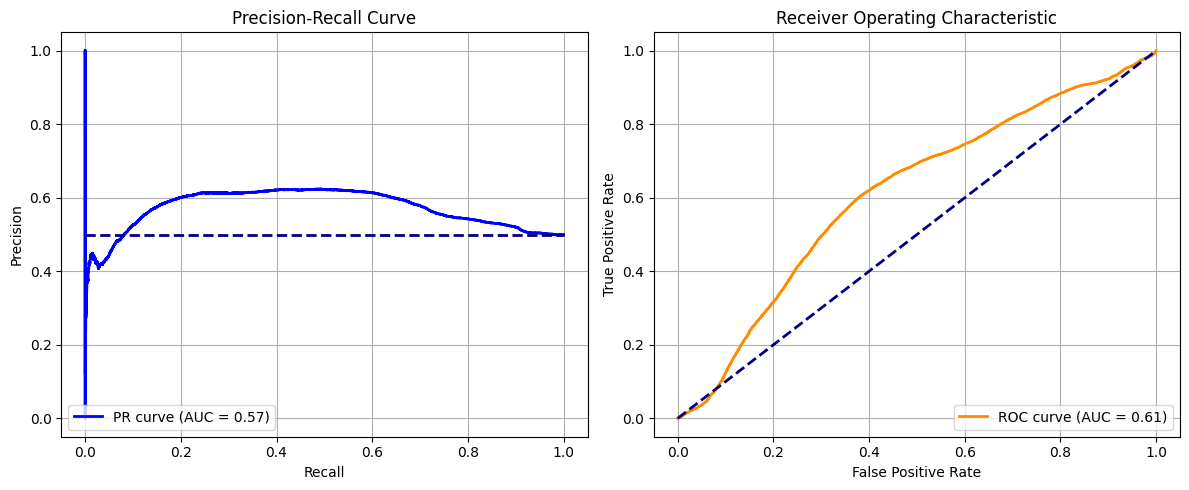

{'pr_auc': 0.5679749481968842, 'roc_auc': 0.6120692155286149, 'precision': 0.5719949081651189, 'recall': 0.7119188809922561, 'f1': 0.6343322711561735, 'threshold': 0.4}


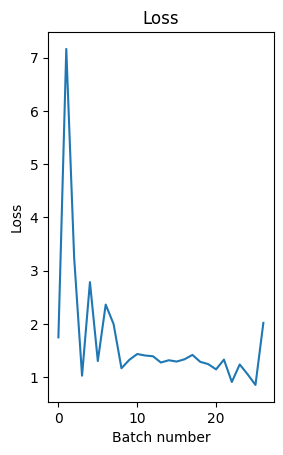

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import numpy as np

def calc_metrics(predictions, targets, threshold=0.5):
    """Calculate metrics and plot Precision-Recall & ROC curves"""
    # Convert to numpy
    y_true = targets.cpu().numpy()
    y_scores = predictions.cpu().numpy()  # Convert logits to probabilities
    
    # --- Precision-Recall Curve ---
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, color='blue', lw=2, 
             label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.plot([0, 1], [0.5, 0.5], color='navy', lw=2, linestyle='--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    
    # --- ROC Curve ---
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(list(range(len(epochs_losses[0]))), epochs_losses[0])
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    plt.title('Loss')
    
    # --- Threshold-based Metrics ---
    preds = (y_scores > threshold).astype(float)
    tp = np.sum((preds == 1) & (y_true == 1))
    fp = np.sum((preds == 1) & (y_true == 0))
    fn = np.sum((preds == 0) & (y_true == 1))
    
    precision_at_thresh = tp / (tp + fp + 1e-10)
    recall_at_thresh = tp / (tp + fn + 1e-10)
    f1 = 2 * (precision_at_thresh * recall_at_thresh) / (precision_at_thresh + recall_at_thresh + 1e-10)
    
    return {
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'precision': precision_at_thresh,
        'recall': recall_at_thresh,
        'f1': f1,
        'threshold': threshold
    }

# Usage
metrics = calc_metrics(
    torch.cat(epochs_metrics[0][0]).detach(),  # Predictions
    torch.cat(epochs_metrics[0][1]).detach(),  # Targets
    threshold=0.4
)
print(metrics)

In [57]:
torch.save(metamodel, './model/metamodel.pth')
torch.save(task_model, './model/task_model.pth')

In [ ]:
# TODO: fix internal call error in data
# TODO: fix slow one-threaded json parsing